# Deep Kalman Filter 
**Fully-stochastic recurrent-neural network**


In this notebook, we test the capabilities of a DKF to recover the latent space. We consider a Lotka-Volterra model with added noise as a latent space, and the identity function with added noise and an MLP with randomly-initialised noise as the observed space.

## The inference model of a DKF is given by


$$
\begin{aligned}
    p_{\theta_{\bf z}}({\bf z}_t\vert {\bf x}_{1:t-1}, {\bf z}_{1:t-1}, {\bf u}_{1:t-1}) &= p_{\theta_{\bf z}}({\bf z}_t \vert {\bf z}_{t-1}, {\bf u}_t)\\
    p_{\theta_{\bf z}}({\bf x}_t \vert {\bf x}_{1:t-1} z_{1:t}, {\bf u}_{1:t}) &= p_\theta({\bf x}_t \vert {\bf z}_t)
\end{aligned}
$$

In [1]:
import jax
import chex
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from functools import partial

In [2]:
%config InlineBackend.figure_format = "retina"

## Designing the latent space

In [17]:
@chex.dataclass
class ParamsLatent:
    alpha: float
    beta: float
    delta: float
    gamma: float
    dt: float
    noise: float


@chex.dataclass
class ParamsObserved:
    noise: float
    projection: chex.ArrayDevice

In [4]:
def latent_step(z_prev, key, params):
    z1, z2 = z_prev
    noise = jax.random.normal(key) * params.noise * jnp.sqrt(params.dt)
    
    z1_next = params.alpha * z1 - params.beta * z1 * z2
    z2_next = params.delta * z1 * z2 - params.gamma * z2
    z_next = jnp.array([z1_next, z2_next])
    
    z_next = z_prev + params.dt * z_next + noise
    
    return z_next, z_next


def simulate_lv(key, z0, n_steps, params):
    """
    Simulate a Lotka-Volterra model
    """
    keys = jax.random.split(key, n_steps)
    latent_step_part = partial(latent_step, params=params)
    _, z_hist = jax.lax.scan(latent_step_part, z0, keys)
    return z_hist 


simulate_lv_vmap = jax.vmap(simulate_lv, (0, None, None, None))

In [5]:
n_simulations = 25
n_steps = 1_000
key = jax.random.PRNGKey(314)
keys_sims = jax.random.split(key, n_simulations)
params = ParamsLatent(alpha=2/3, beta=4/3, delta=1, gamma=1, dt=0.01, noise=0.04)

z0 = jnp.array([1, 1.0])
z_sims = simulate_lv_vmap(keys_sims, z0, n_steps, params)
z_sims.shape

(25, 1000, 2)

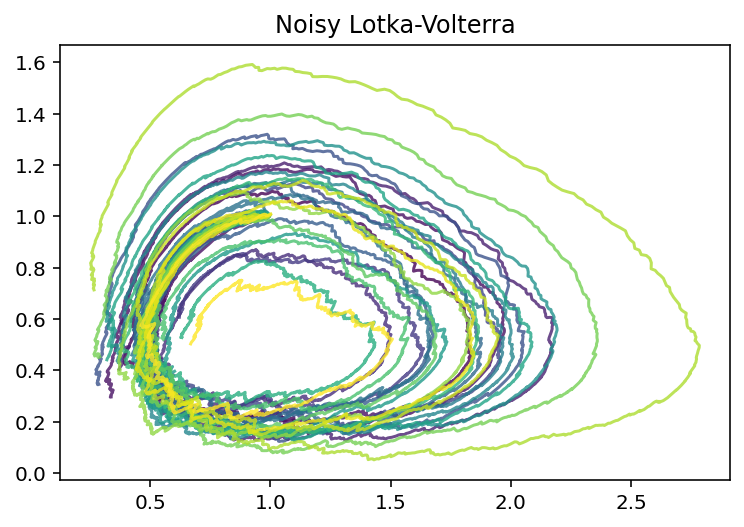

In [6]:
colors = plt.cm.viridis(jnp.linspace(0, 1, n_simulations))
for n, sim in enumerate(z_sims):
    plt.plot(*sim.T, alpha=0.8, color=colors[n])
plt.title("Noisy Lotka-Volterra");

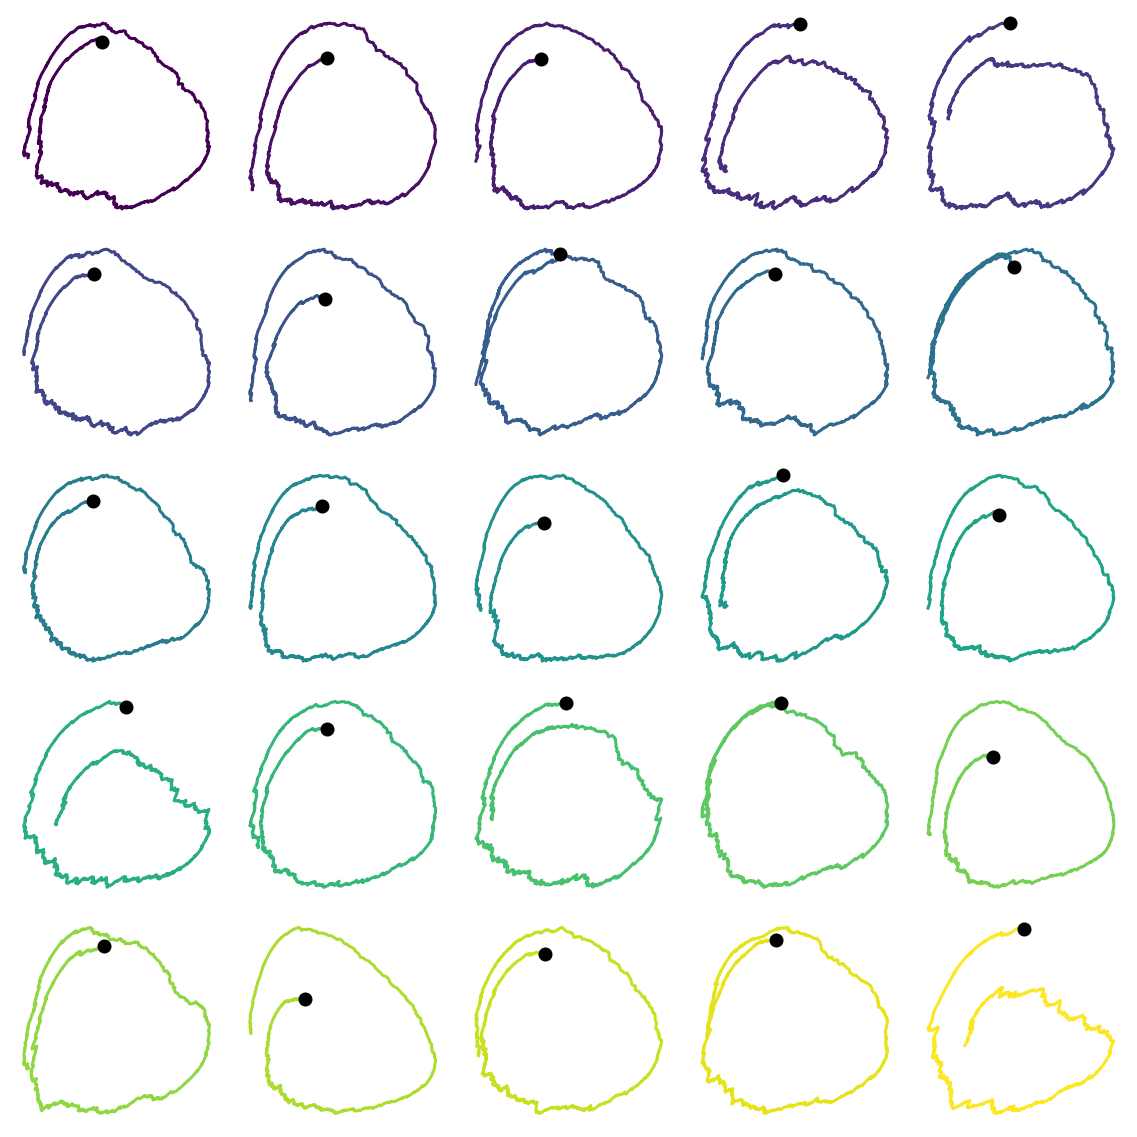

In [7]:
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
axs = axs.ravel()
for n, (ax, z_sim) in enumerate(zip(axs, z_sims)):
    ax.plot(*z_sim.T, c=colors[n], zorder=0)
    ax.scatter(*z0, c="black", zorder=1)
    ax.axis("off")
plt.tight_layout()

## Designing the observed space
### 1. Identity + Gaussian noise

In [21]:
def latent_step(key, z_prev, params):
    z1, z2 = z_prev
    noise = jax.random.normal(key) * params.noise * jnp.sqrt(params.dt)
    
    z1_next = params.alpha * z1 - params.beta * z1 * z2
    z2_next = params.delta * z1 * z2 - params.gamma * z2
    z_next = jnp.array([z1_next, z2_next])
    
    z_next = z_prev + params.dt * z_next + noise
    
    return z_next


def observed_step(key, z_val, params):
    """
    Observed step is simply the current latent
    observed value + gaussian noise
    """
    noise = jax.random.normal(key, (2,)) * params.noise
    obs = params.projection @ z_val + noise
    return obs

def step_latent_observed(z_prev, key, latent_fn, observed_fn,
                             params_latent, params_obs):
    key_latent, key_obs = jax.random.split(key)
    
    z_next = latent_fn(key_latent, z_prev, params_latent)
    x_next = observed_step(key_obs, z_next, params_obs)
    
    res = {
        "latent": z_next,
        "observed": x_next
    }
    return z_next, res
    

def simulate_latent_observed(key, z0, n_steps, latent_fn, observed_fn,
                             params_latent, params_obs):
    keys = jax.random.split(key, n_steps)
    part_step_latent_obs = partial(step_latent_observed,
                                   latent_fn=latent_fn,
                                   observed_fn=observed_fn,
                                   params_latent=params_latent,
                                   params_obs=params_obs)
    
    _, hist = jax.lax.scan(part_step_latent_obs, z0, keys)
    return hist


multiple_simulate_latent_observed = jax.vmap(simulate_latent_observed,
                                             in_axes=(0, None, None, None, None, None, None))

In [22]:
proj_matrix = jnp.eye(2)
proj_matrix

DeviceArray([[1., 0.],
             [0., 1.]], dtype=float32)

In [23]:
key = jax.random.PRNGKey(314)
z0 = jnp.array([1, 1.0])
params_latent = ParamsLatent(alpha=2/3, beta=4/3, delta=0.8, gamma=1, dt=0.01, noise=0.04)
params_obs = ParamsObserved(projection=proj_matrix, noise=0.05)

n_steps = 1500
n_simulations = 25
keys = jax.random.split(key, n_simulations)

simulations = multiple_simulate_latent_observed(keys, z0, n_steps, latent_step, observed_step,
                                                params_latent, params_obs)

In [24]:
z_sims = simulations["latent"]
x_sims = simulations["observed"]

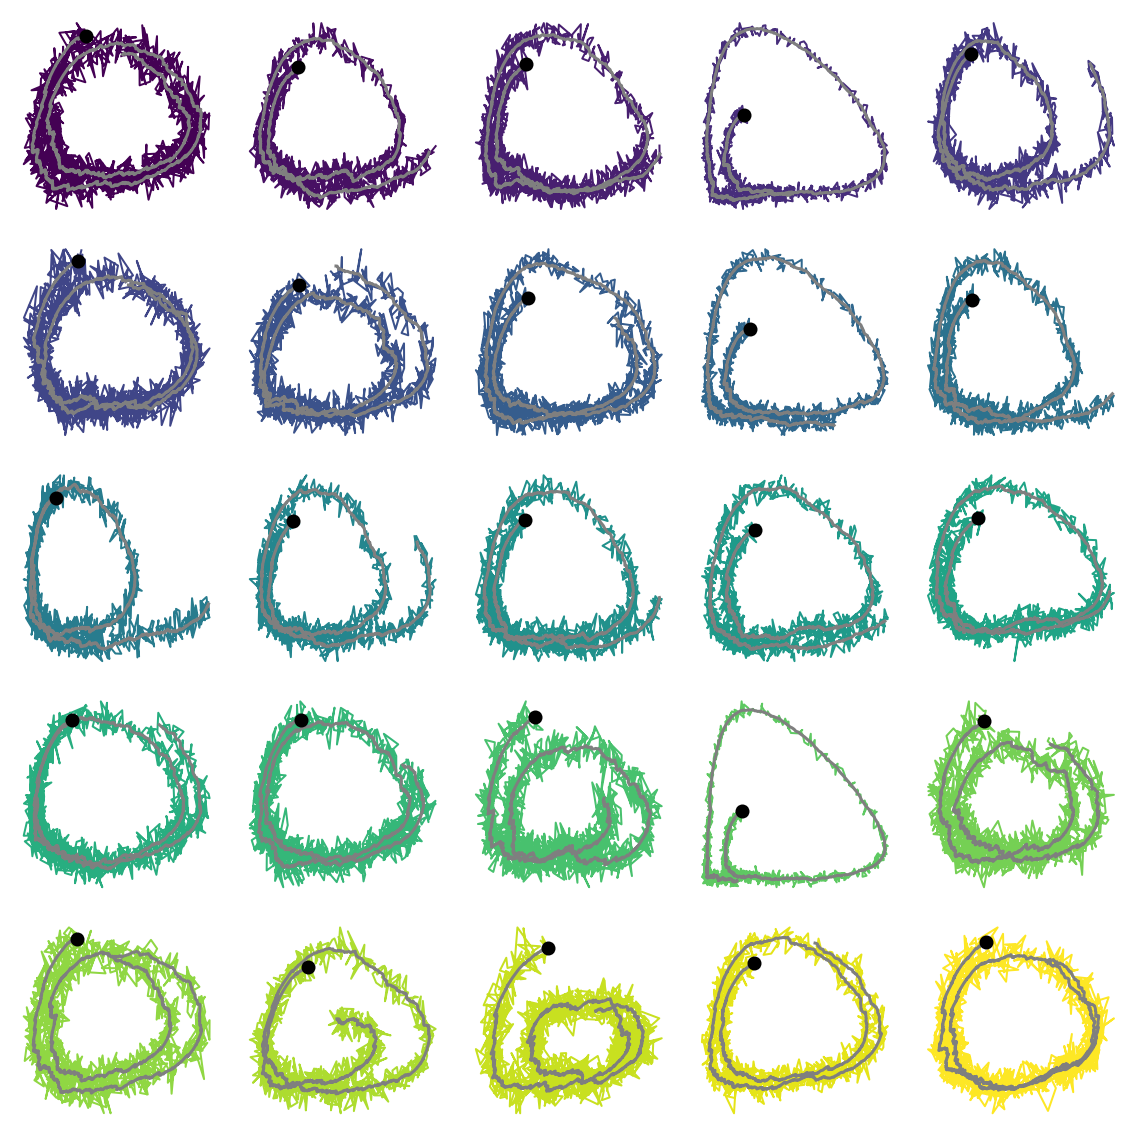

In [25]:
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
colors = plt.cm.viridis(jnp.linspace(0, 1, n_simulations))

axs = axs.ravel()
for n, (ax, z_sim, x_sim) in enumerate(zip(axs, z_sims, x_sims)):
    ax.plot(*x_sim.T, c=colors[n], zorder=0, linewidth=1)
    ax.plot(*z_sim.T, c="tab:gray", zorder=1)
    ax.scatter(*z0, c="black", zorder=2)
    ax.axis("off")
plt.tight_layout()

## Recurrent neural network


We first asses the performance of an RNN to sample a Lotka-Volterra simulation. We consider the inputs of this model to be the observed state and the output the latent space. Then, given an unobserved path, how well can

## References

* [Euler-Mayurama method](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method)
* [Lotka-Volterra equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations)